# Prelogue
Here we present comprehensive guide from raw expert-annotated data to training and predicting spikelet pubescence feature of wheat spikes.  
Current version is only usable inside Naga server of icgbio.ru

In [1]:
from config import PROJECT_DIR, DATA_DIR, PATTERNS

## 0. Data Parsing

In [2]:
from preprocessing import DataPreprocessor
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt

We have raw .txt file with annotation data. First we pricess that file and convert it to .csv. But we firstly have to create our entity with relative path to **PROJECT_DIR** in config.py

In [2]:
processor = DataPreprocessor('raw_labels_data')

In [3]:
df = processor.process_raw_annotation()

Let's see our df

In [4]:
df.head(10)

,Номер_каталога,Вид,Опушение,Вегетация,Подвиды
0,PI 289599,T. monococcum,0,X-19,7961-68
0,к-20491,T. monococcum,1,X-19,8021-30
0,к-18140,T. monococcum,0,X-19,8032-39
0,PI 345242,T. monococcum,0,X-19,8071-80
0,PI 362610,T. monococcum,0,X-19,8081-90
0,к-18105,T. monococcum,0,X-19,8091-99
0,Wat,T. monococcum,1,X-19,8101-06
0,к-20634,T. monococcum,0,X-19,8111-20
0,к-8555,T. monococcum,0,X-19;II-20,8131-38;216-222
0,PI 355537,T. monococcum,0,X-19,8172-79


## 1. Exploratory Data Analysis

Now we have DataFrame. Let's do basic EDA with that data. Later we will create another dataframe with information about images by species. 

Firstly, let's compute number of subspecies of each species

In [5]:
len(df['Вид'].unique())

19

Let's get coprehensive stats about our data

In [6]:
stats = processor.dataset_stats()

In [7]:
stats.head(10)

,Вид,Плоидность,Опушение,Тип_изображений,Подвиды,Опушенные,Неопушенные,Всего
0,T. monococcum,Диплоиды,0,pin,293-305,0,28,28
1,T. monococcum,Диплоиды,0,pin,322-330,0,32,32
2,T. monococcum,Диплоиды,0,pin,226-235,0,32,32
3,T. monococcum,Диплоиды,0,pin,8111-20,0,40,40
4,T. monococcum,Диплоиды,0,pin,8111-20,0,0,0
5,T. monococcum,Диплоиды,0,pin,8111-20,0,0,0
6,T. monococcum,Диплоиды,0,pin,8111-20,0,0,0
7,T. monococcum,Диплоиды,0,pin,8111-20,0,0,0
8,T. monococcum,Диплоиды,0,pin,8111-20,0,0,0
9,T. monococcum,Диплоиды,0,pin,8081-90,0,36,36


Number of images with and without pubescence

In [8]:
with_pubesc = stats['Опушенные'].sum()
without_pubesc = stats['Неопушенные'].sum()
print(f'With pubescence: {int(with_pubesc)}')
print(f'Without pubescence: {int(without_pubesc)}')
print(f'Overall: {with_pubesc + without_pubesc}')

With pubescence: 3304
Without pubescence: 6375
Overall: 9679


In [9]:
all_pin = stats[stats['Тип_изображений'] == 'pin']['Всего'].sum()
all_table = stats[stats['Тип_изображений'] == 'table']['Всего'].sum()
print(f'Overal pin images: {all_pin}')
print(f'Overall table images: {all_table}')

Overal pin images: 7743
Overall table images: 1936


Let's remove subspecies with no annotated images. Then we want to compute number of unqiue subspicies. Note, that we have duplicates because of using two image protocols *pin* and *table*

In [10]:
tmp = stats[stats['Всего'] > 0]

In [11]:
tmp = tmp[['Подвиды', 'Опушение']]

In [12]:
pubesc_df = tmp[tmp['Опушение'] == 1]
non_pubesc_df = tmp[tmp['Опушение'] == 0]

# now we choose only unique elements
num_pubesc_subspecies = len(pubesc_df['Подвиды'].unique())
num_non_pubesc_subspecies = len(non_pubesc_df['Подвиды'].unique())
                               
print(f'Number of subspecies with pubescence: {num_pubesc_subspecies}')
print(f'Number of subspecies without pubescence: {num_non_pubesc_subspecies}')

Number of subspecies with pubescence: 77
Number of subspecies without pubescence: 145


Note, that some subspecies may have two diffrenet values of pubescence feature. It depends on vegetation.

Finally, let's plot hystogram of species distribution

In [13]:
tmp = stats[stats['Всего'] > 0][['Вид', 'Опушенные', 'Неопушенные', 'Всего']]

In [14]:
species = tmp.groupby('Вид').sum().sort_values(by='Всего')
species

,Опушенные,Неопушенные,Всего
Вид,,,
T. sphaerococcum,50,50,100
T. urartu,20,105,125
T. compactum,0,135,135
T. boeoticum,65,80,145
T. yunnanense,85,95,180
T. vavilovii,180,0,180
T. spelta,50,140,190
T. macha,76,220,296
T. aestivum,65,280,345


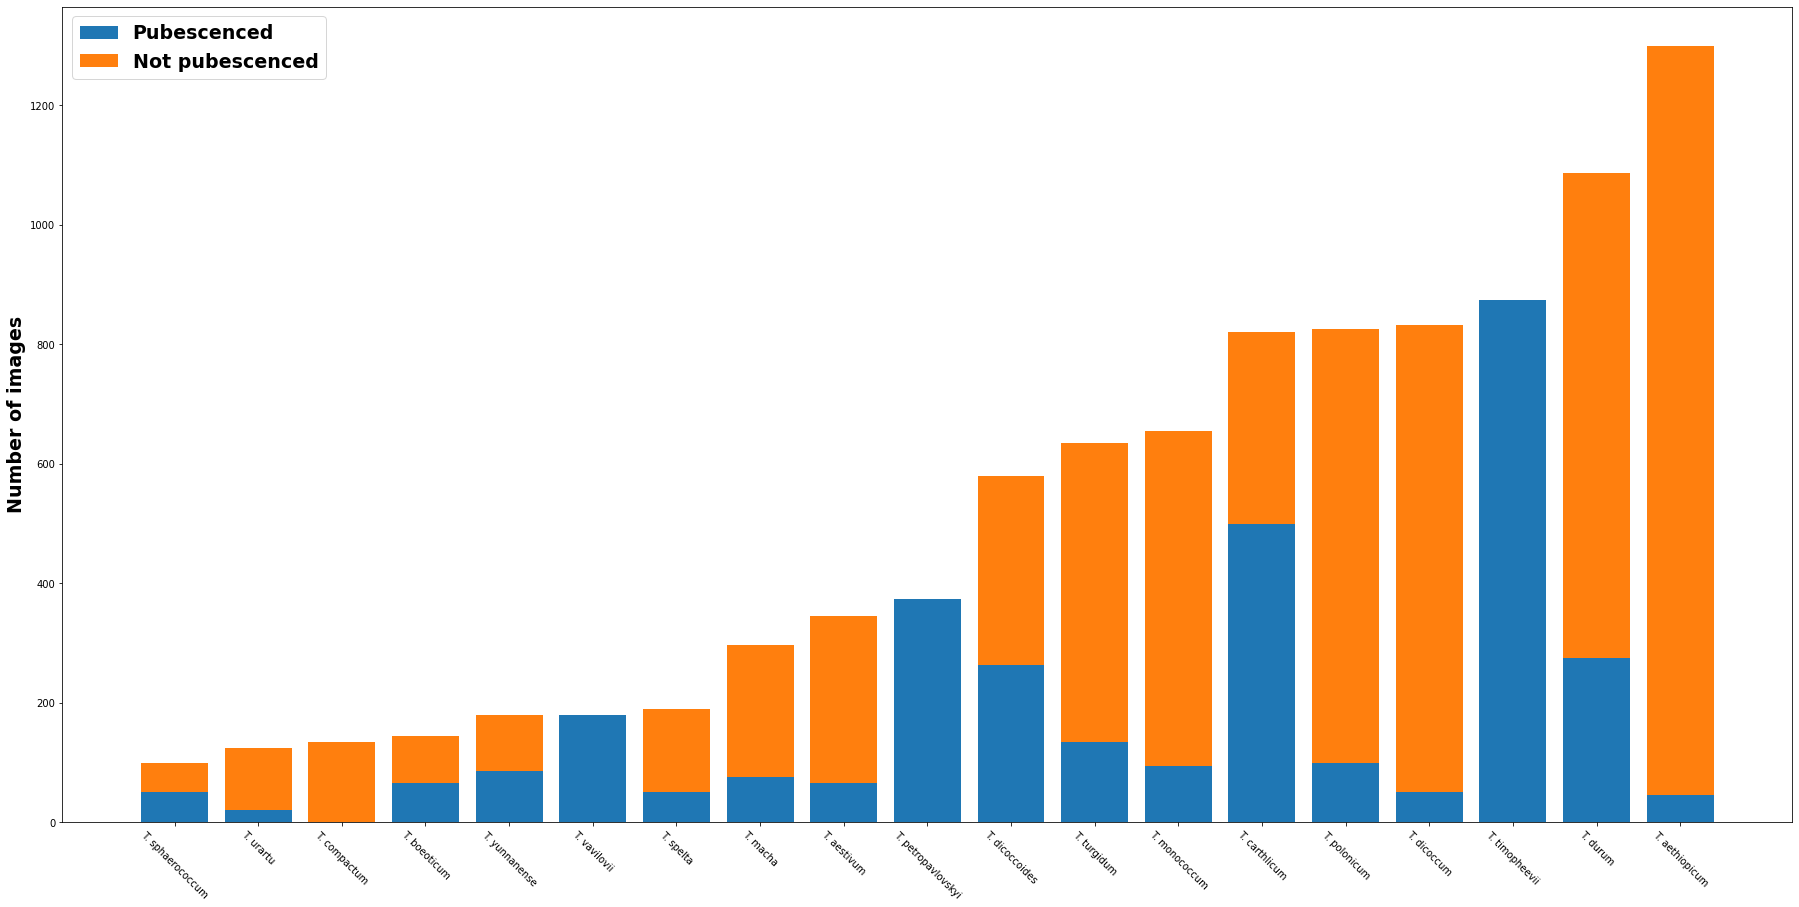

In [15]:
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(31,15))
font = {'size': 19, 'weight': 'bold'}

ax.bar(species.index, species['Опушенные'], label='Pubescenced')
ax.bar(species.index, species['Неопушенные'], bottom=species['Опушенные'], label='Not pubescenced')

ax.set_ylabel('Number of images', fontsize=19, fontweight='bold')
plt.xticks(rotation=-45)
matplotlib.rc('font', **font)
ax.legend()

## 2. Stratification methods

In that project we used two stratification methods. First is manual with attemp to save the most species for training sample. Second is by iterative algorithm with optimizing difference of balance of classes. You may get results of that algorithm using method **processor.form_optimal_random_split**

In [16]:
optimal_split, ratios = processor.form_optimal_random_split()

The choice now is better: 0.4604987633292257
The choice now is better: 0.3552777090038789
The choice now is better: 0.19173534798534803
The choice now is better: 0.16960991038481815
Final choice: 0.16960991038481815
Time consumed 3.416563034057617


Here ratios is the coefficients $$k = \frac{\text{without pubescence}}{\text{with pubecence}} $$  
for each subsample *train, valid, test*

Now we have algorithm that stratificate our data. Final stage before applying machine learning methods is to create annotation file. For that aim you may use **processor.create_annotation_file()** and pass dictionary of species. By default (without argument) annotation_file will devide all images into three group with default *ratio=[0.8, 0.1, 0.1]*, you may also add ratio as argument.  
It's also necessary to pass name of your file *filename=*  
Formed .csv file will be saved into PROJECT_DIR.

In [17]:
split_dict = {'train': optimal_split[0], 'valid': optimal_split[1], 'test': optimal_split[2]}

Here we create file with random split and will try to train model with that split later

In [18]:
processor.create_annotation_file(filename='purely_random_split')

## 3. Segmentation and preprocessing

For segmentation as well as annotation preprocessing it's required to use **preprocessing.py** method

Method **preprocessing.get_mask(img_imput_path, save_mask=False)** takes absolute path to image and return mask. If you specify save_mask=True, the mask will be saved into your current directory.

Note, that this method is slow because of using executable file with segmentation model. It's recommended to read data from drive if masks have been aquired earlier

[17546] WARNING: file already exists but should not: /tmp/_MEIQiMFq6/torch/_C.cpython-36m-x86_64-linux-gnu.so
[17546] WARNING: file already exists but should not: /tmp/_MEIQiMFq6/torch/_dl.cpython-36m-x86_64-linux-gnu.so
2023-09-06 13:22:15,797 - __main__ - INFO - EVAL_AUG Compose([
  Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})
2023-09-06 13:22:15,797 - __main__ - INFO - BACKBONE efficientnet-b2
2023-09-06 13:22:15,797 - __main__ - INFO - MODELNAME model_efficientnet-b2.bin
2023-09-06 13:22:15,797 - __main__ - INFO - CUDA True
2023-09-06 13:22:15,797 - __main__ - INFO - BATCH_SIZE 32
2023-09-06 13:22:15,797 - __main__ - INFO - IMGPATH /home/jupyter-n.artemenko/projects/spikelet_pubescence/Data/28n4_3_{V-21}.jpg
2023-09-06 13:22:15,797 - __main__ - INFO - OUTPATH /home/jupyter-n.artemenko/projects/spikelet_pubescence
2023-09-06 13:22:15,797 - _

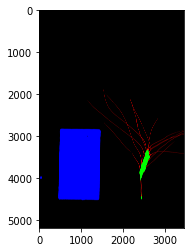

In [26]:
from preprocessing import get_mask
from matplotlib import pyplot as plt

mask = get_mask(f'{PROJECT_DIR}/Data/28n4_3_{{V-21}}.jpg')
plt.imshow(mask[:, :, ::-1])

There also also two methods used to create and save masks. They don't take any arguments and sharped by holdout and original datasets

In [6]:
import cv2
from preprocessing import get_dataset_masks, get_holdout_masks

Note, that we have only raw mask. To get bboxes there are also three methods. 

For single image we use **preprocessing.get_bbox(raw_img, mask, dilation=False)** method

In [8]:
from preprocessing import get_bbox

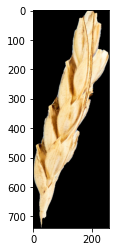

In [11]:
img = cv2.imread(f'{PROJECT_DIR}/Data/28n4_3_{{V-21}}.jpg')

bbox = get_bbox(img, mask, dilation=False)
plt.imshow(bbox[:, :, ::-1])

Final preprocessing bbox methods as well as for masks include: **make_all_bboxes(overwrite=False, dilation=False)** and **make_all_holdout_bboxes(overwrite=False, dilation=False)**

In [12]:
from preprocessing import make_all_bboxes, make_all_holdout_bboxes

## 4. Training and evaluating

In [14]:
from config import PROJECT_DIR, DATA_DIR, PATTERNS
from training_config import training_params, augmentations
from dataset import SpikeDataset, HoldoutDataset, balance_dataset
from model import Model

import numpy as np
import os
import cv2
import time
import random
import re
from matplotlib import pyplot as plt
from sklearn import metrics 

We have our split. Now we want to train model on that data.

Let's introduce known splits to simplify further usage. All of these splits are awailable in *{PROJECT_DIR}/splits* folder

In [15]:
random_best_split = 'random_best_split.csv'
first_split = 'first_split.csv'
first_renewed_split = 'first_split_renewed.csv'
holdout = 'holdout_annotation.csv'
purely_random_split = 'purely_random_split.csv'

Now we create dataset class with known source split using **SpikeDataset(annotation_file, group, verbose=False)**. Last parameter impact on output if we're using indexing. If *verbose=True* method __getitem__() returns image, label and additional dictionary with information about species, subspecies and so on. This configuration was made to research prediction quality and species belonging and may be use for any type of analysis

In [16]:
data_source = purely_random_split
train_data = SpikeDataset(data_source, 'train')
valid_data = SpikeDataset(data_source, 'valid')
test_data = SpikeDataset(data_source, 'test')
holdout_data = HoldoutDataset(holdout, 'test')

Let's test how easily we may get data from that dataset

In [25]:
start = time.time()
sample_dataset = train_data
idx = random.randrange(0, len(sample_dataset))
print(idx)
print('Image shape:', sample_dataset[idx][0].shape)
print('Pubescence:', sample_dataset[idx][1])
print('One iteration takes:', f'{time.time() - start:.3f}', 'sec.')

957
Image shape: (3, 512, 512)
Pubescence: 0
One iteration takes: 0.095 sec.


Define save folder, model_name, model_class. Note, that model_name defines which model will be used. Check **training_config.py** to change params of training.

In [5]:
save_path = f'{PROJECT_DIR}/runs'
model_name = 'efficientnet_b1'
model_class = Model(model_name, save_path)

If model was trained previously - you may load weights

In [6]:
model_class.load('best_manual')
# model_class.load('best_random')
# model_class.load(run_name='run1')

In [7]:
if not model_class.isfitted():
    model_class.fit(train_data=train_data, valid_data=valid_data)

Inference to compute metrics

In [8]:
model_class.inference(holdout_data)

accuracy_score: 0.825
precision_score: 0.782608695652174
roc_auc_score: 0.8925000000000001
loss: 0.7109013929067259


Also you may get predicted labels or probabilities using **model_class.predict(generator)** and **model_class.predict_proba(generator)**. Instead of generator you may use any itarable object with images as np.arrays()

In [9]:
model_class.predict(holdout_data.images())

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [11]:
holdout_data.labels()

<generator object SpikeDataset.labels at 0x7f11969bb350>

Class activation map on random image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target is: 1
Prediction is: 1


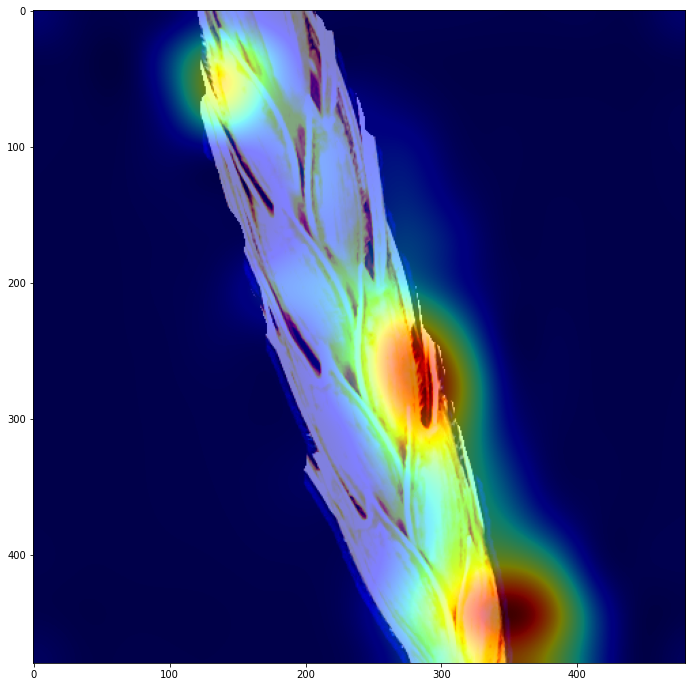

In [14]:
model_class.random_class_activation_map(holdout_data)